# Australian Boreholes

Looking at the data from the [**Australian Borehole Stratigraphic Unit Compilation**](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/147641) 2023 v1.0

In [249]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as plt
import pygmt
from joblib import Parallel, delayed
import requests
import zipfile
import io
import os
from shapely import Point
from tqdm import tqdm
import re

from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException 

In [35]:
absuc = pd.read_csv("../data/ABSUC/ABSUC_v1_BASE.txt")  # preferred stratigraphic picks for the base of each unit
absuc.set_index("GA_GUID", inplace=True)
# remove entries with NaNs in the seemingly relevant depth measurements
absuc.dropna(
    axis=0,
    subset=("TD_MD_M", "TOP_MD_M", "BASE_MD_M", "TOP_AHD_M", "BASE_AHD_M"),
    inplace=True,
)

# remove some irrelevant columns
absuc.drop(
    labels=[
        "OBJECTID",
        "GA_ENO",
        "UWI",
        "GL_AHD_M",
        "WD_AHD_M",
        "SRTM_HE_AHD_M",
        "DATUM_ELEVATION_AHD_M",
        "DATA_SOURCE",
        "GA_HYDROSTRAT",
        "TAG",
        "Z_M_SRTM",
        "COMMENT",
    ],
    axis=1,
    inplace=True
)

absuc.shape

/var/folders/t6/g_v51vw92p98wh69ncgrb0mh0000gn/T/ipykernel_60053/3004378177.py:1: DtypeWarning: Columns (4,28) have mixed types. Specify dtype option on import or set low_memory=False.
  absuc = pd.read_csv("../data/ABSUC/ABSUC_v1_BASE.txt")  # preferred stratigraphic picks for the base of each unit


(379493, 16)

In [130]:
# Get unique boreholes (HIERARCHY == min)
# THIS TAKES A WHILE!
# Running as a loop is faster than parallelising with joblib because of startup cost of lots of little processes.  Could potentially batch.
ids = absuc["GA_BOREHOLE_GUID"].unique()
_drop_these = []
for _id in tqdm(ids):
    subset = absuc[absuc["GA_BOREHOLE_GUID"] == _id]
    best = np.min(subset["HIERARCHY"].unique())
    _drop_these.append(subset[subset["HIERARCHY"] != best].index.values)
_drop_these = np.concatenate(_drop_these)
absuc.drop(_drop_these, axis=0, inplace=True)
del _drop_these
absuc.shape

100%|██████████| 114584/114584 [25:27<00:00, 75.00it/s]


In [112]:
# create geometry
absuc["geometry"] = absuc.apply(lambda x: Point(x.GDA94_LONGITUDE, x.GDA94_LATITUDE), axis=1)
absuc = gpd.GeoDataFrame(absuc)

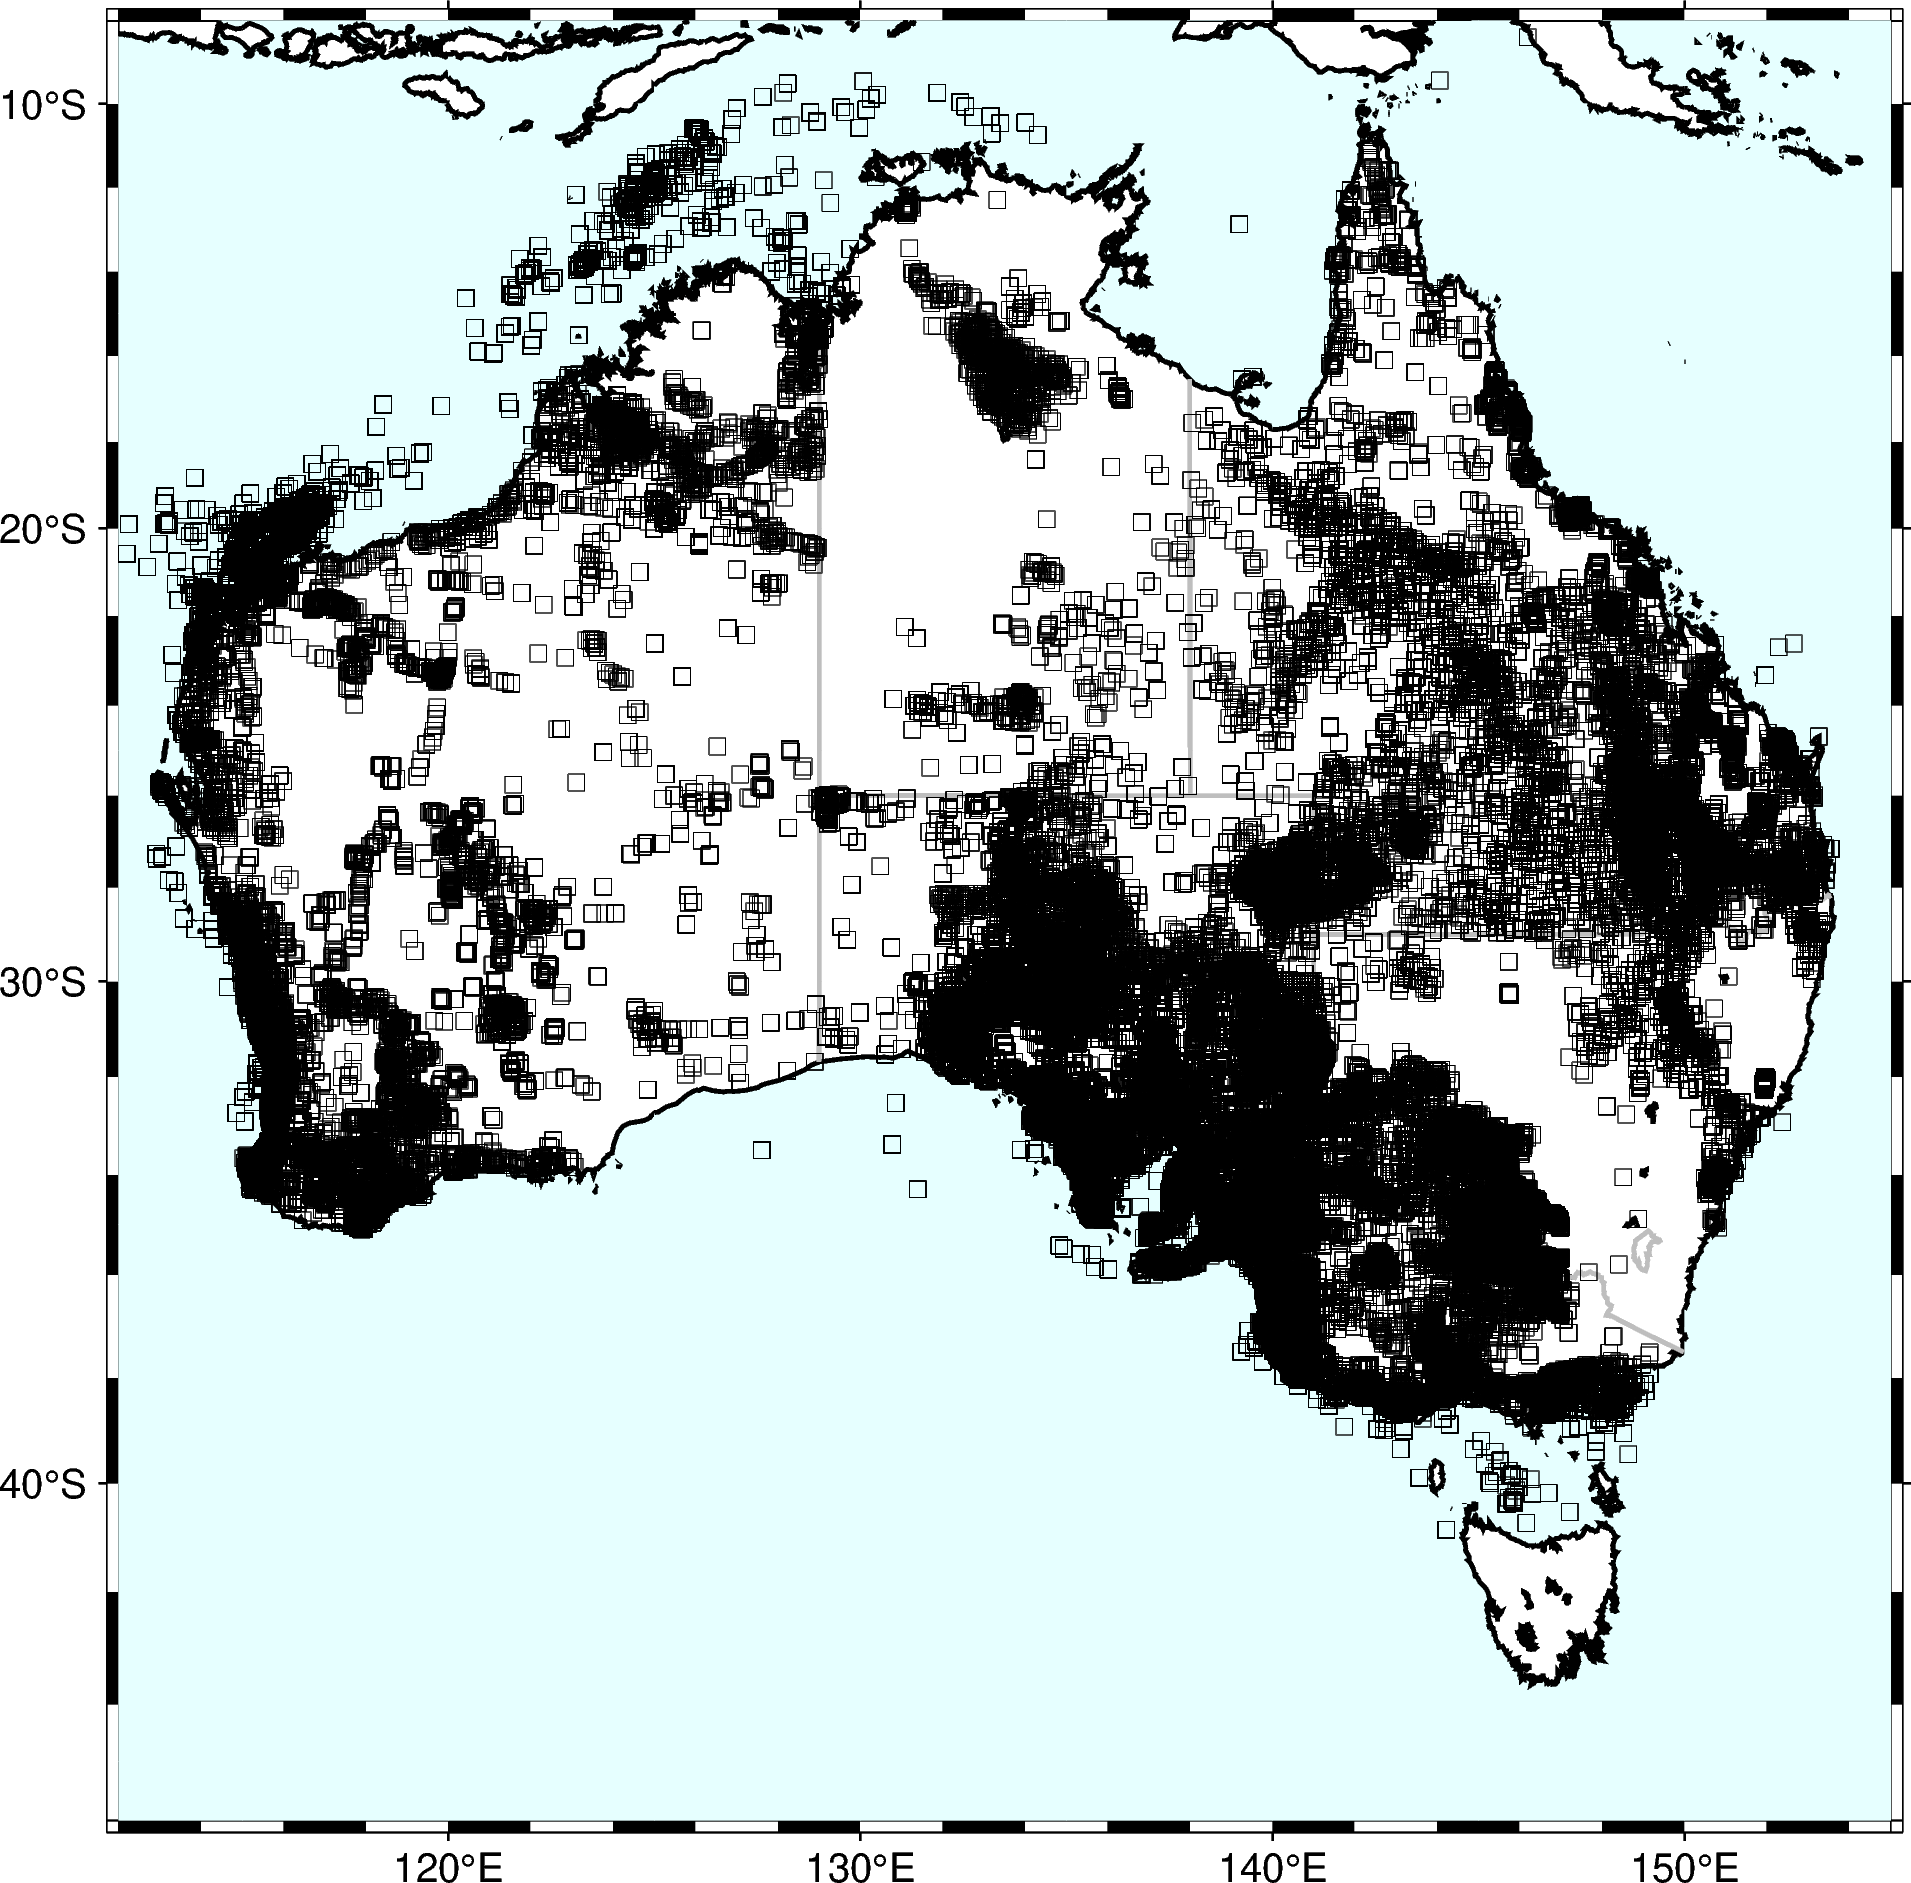

In [138]:
fig = pygmt.Figure()
fig_width = 15
region=[112, 155, -46, -8]
ln_min, ln_max, lt_min, lt_max = region
projection = f"M{int(np.mean([ln_min, ln_max]))}/{int(np.mean([lt_min, lt_max]))}/{fig_width}c"
fig.basemap(region=region, projection=projection, frame=True)
fig.coast(
    region=region,
    projection=projection,
    shorelines=1,
    resolution="i",
    water="#e6ffff",
    borders="2/1p,grey",
)
x = absuc.GDA94_LONGITUDE
y = absuc.GDA94_LATITUDE
fig.plot(x=x,
         y=y,
         style=f"sc",
         pen="0.1p",
         size=np.full_like(x, 0.2))
fig.show()

In [167]:
absuc[absuc["GA_BOREHOLE_GUID"] == "{412fc35f-d103-4b74-8ff7-751dbc86e18c}"]

,GA_BOREHOLE_GUID,BOREHOLE_NAME,GDA94_LATITUDE,GDA94_LONGITUDE,DATUM_NAME,TD_MD_M,SOURCE_UNIT,GA_UNIT,GA_ASUD_NO,TOP_MD_M,BASE_MD_M,TOP_AHD_M,BASE_AHD_M,Z_AHD_M,HIERARCHY,PREFERRED,geometry
GA_GUID,,,,,,,,,,,,,,,,,
{5407c45e-d4f0-4e83-ae24-6d069d8a0ae7},{412fc35f-d103-4b74-8ff7-751dbc86e18c},Coochilara 1,-28.2179,140.86856,Kelly Bushing (KB),2740.762,Nappamerri Group,Nappamerri Group,13823.0,1901.342,2093.671,-1822.128,-2014.457,-2014.457,250,TB,POINT (140.86856 -28.21790)
{2b10e708-640e-4719-9060-b84cb391461f},{412fc35f-d103-4b74-8ff7-751dbc86e18c},Coochilara 1,-28.2179,140.86856,Kelly Bushing (KB),2740.762,Toolachee Formation,Toolachee Formation,18357.0,2093.671,2220.468,-2014.457,-2141.254,-2141.254,250,TB,POINT (140.86856 -28.21790)
{c7b67079-9801-4428-8d8c-e0559651bd3f},{412fc35f-d103-4b74-8ff7-751dbc86e18c},Coochilara 1,-28.2179,140.86856,Kelly Bushing (KB),2740.762,Daralingie Formation,Daralingie Formation,5198.0,2220.468,2229.917,-2141.254,-2150.703,-2150.703,250,TB,POINT (140.86856 -28.21790)
{2c884fa6-9ec5-4402-bb2f-011c3c0d1681},{412fc35f-d103-4b74-8ff7-751dbc86e18c},Coochilara 1,-28.2179,140.86856,Kelly Bushing (KB),2740.762,Roseneath Shale,Roseneath Shale,16348.0,2229.917,2297.582,-2150.703,-2218.368,-2218.368,250,TB,POINT (140.86856 -28.21790)
{7fe5566a-391b-4477-a21c-c303fca51f23},{412fc35f-d103-4b74-8ff7-751dbc86e18c},Coochilara 1,-28.2179,140.86856,Kelly Bushing (KB),2740.762,Epsilon Formation,Epsilon Formation,6221.0,2297.582,2351.227,-2218.368,-2272.013,-2272.013,250,TB,POINT (140.86856 -28.21790)
{6ea43f00-c561-485d-9664-f31c63917a12},{412fc35f-d103-4b74-8ff7-751dbc86e18c},Coochilara 1,-28.2179,140.86856,Kelly Bushing (KB),2740.762,Murteree Shale,Murteree Shale,13586.0,2351.227,2406.091,-2272.013,-2326.877,-2326.877,250,TB,POINT (140.86856 -28.21790)
{2a419bd4-e594-4d80-81aa-4c775453b526},{412fc35f-d103-4b74-8ff7-751dbc86e18c},Coochilara 1,-28.2179,140.86856,Kelly Bushing (KB),2740.762,Patchawarra Formation,Patchawarra Formation,14936.0,2406.091,2718.820,-2326.877,-2639.606,-2639.606,250,TB,POINT (140.86856 -28.21790)
{d82780d8-ade9-4852-acd7-c457d75aeb2e},{412fc35f-d103-4b74-8ff7-751dbc86e18c},Coochilara 1,-28.2179,140.86856,Kelly Bushing (KB),2740.762,Tirrawarra Sandstone/ Merrimelia Formation,Gidgealpa Group,7182.0,2718.820,2740.762,-2639.606,-2661.548,-2661.548,250,TB,POINT (140.86856 -28.21790)


Try a couple boreholes in SA and see if we can estimate something similar to what is given on SARIG

In [142]:
datadir = os.path.join("..", "data", "SA_drillholes")
if not os.path.exists(datadir):
    print("downloading...")
    r = requests.get("https://data.sarig.sa.gov.au/Map/Download/layerDownload?layeId=924&formatLovId=20")
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path=datadir)
    with open(os.path.join(datadir, ".gitignore"), "w") as f:
        f.write("*")
SA = gpd.read_file(os.path.join(datadir, "drillholes_depthtobasement.shp"))
SA.columns

Index(['GDA94_X', 'STRATDESC', 'STRAT_NAME', 'COVR_THICK', 'MAXAGE', 'MINAGE',
       'MAPUNIT', 'ELEVATION', 'BASEMNT_RL', 'ADJLCC_Y', 'ADJLCC_X', 'LCC_Y01',
       'LCC_X02', 'ADJGDA94_Y', 'ADJGDA94_X', 'GDA94_Y03', 'ADJ_ELEV',
       'MAX_DEPTH', 'TO_DEPTH', 'FROM_DEPTH', 'DHNUMBER', 'DH_NAME',
       'geometry'],
      dtype='object')

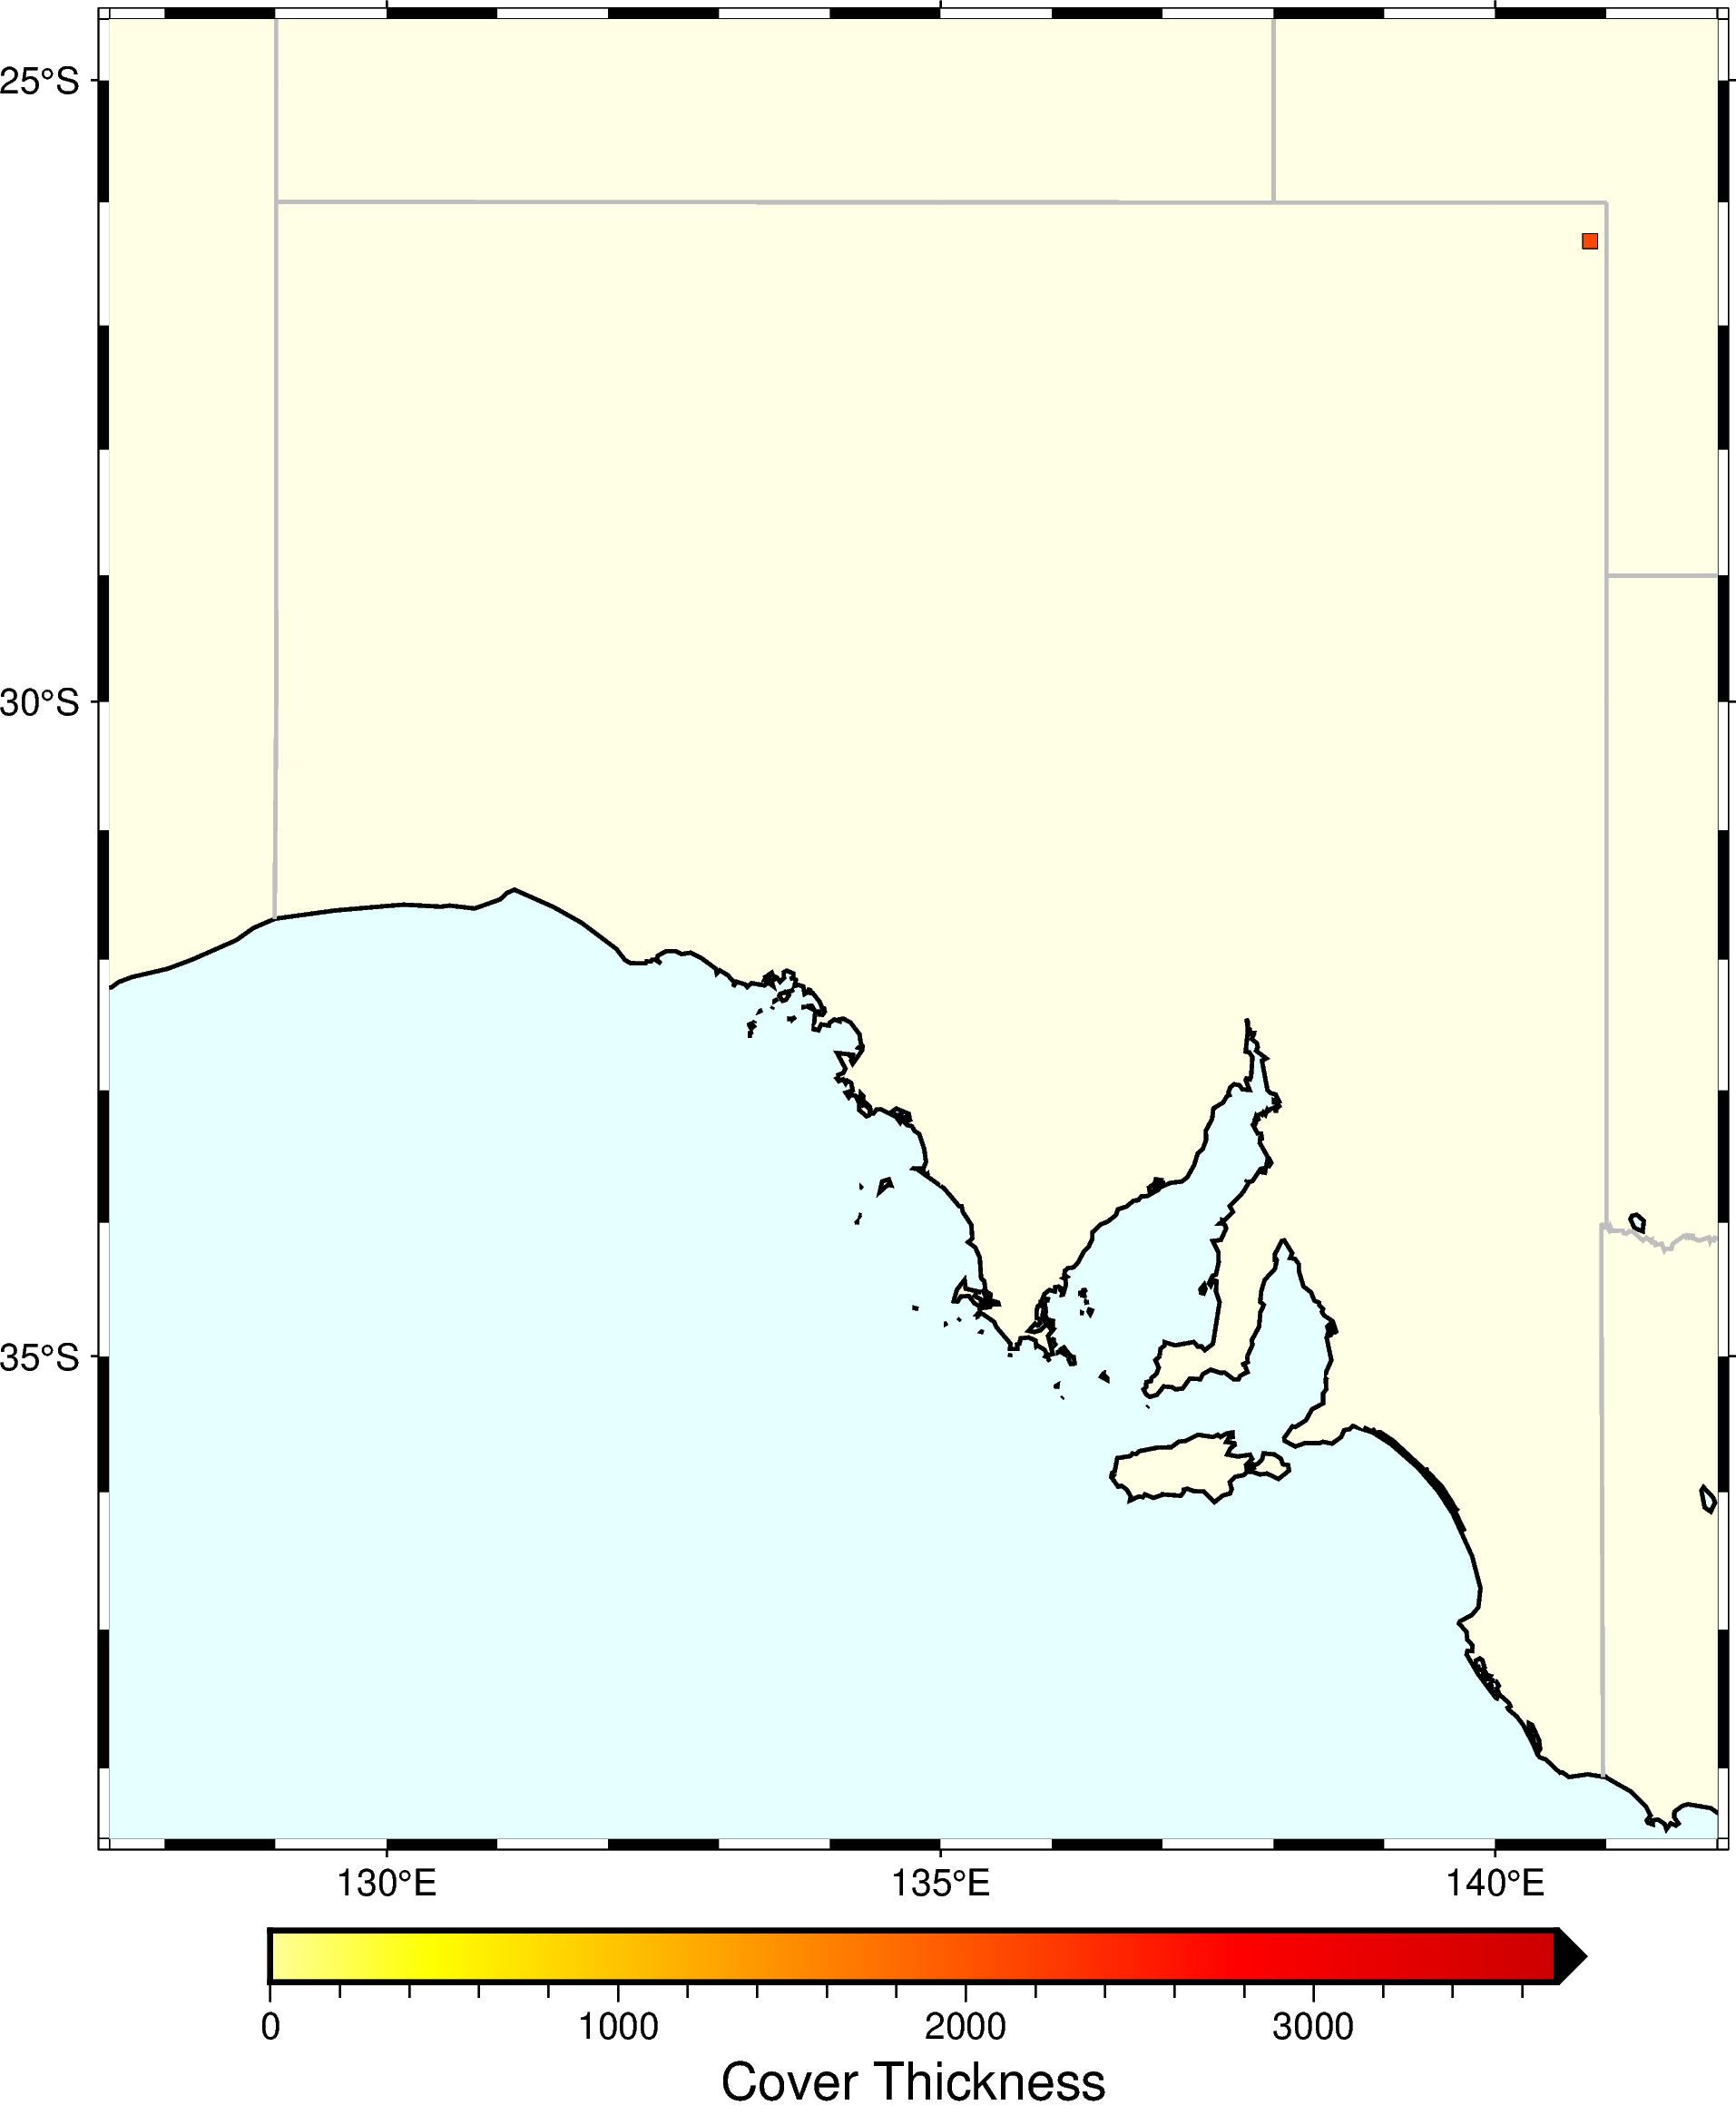

In [161]:
fig = pygmt.Figure()
projection = f"M12/11/15"
ln_min, ln_max = (127.5, 142)
lt_min, lt_max = (-38.5, -24.5)
region = [ln_min, ln_max, lt_min, lt_max]
fig.basemap(region=region, projection=projection)
fig.coast(
    shorelines=1,
    land="#ffffe6",
    water="#e6ffff",
    borders="2/1p,grey",
    projection=projection,
    region=region,
)
pygmt.makecpt(cmap="hot", truncate=[0.3, 0.9], series=[SA.COVR_THICK.min(), SA.COVR_THICK.max()], reverse=True)
x = SA.ADJGDA94_X
y = SA.ADJGDA94_Y
NESA = SA[(x>140) & (y > -30)] #North East South Australia
example_borehole = NESA.iloc[NESA.ADJGDA94_Y.argmax()]
fig.plot(x=[example_borehole.ADJGDA94_X],
         y=[example_borehole.ADJGDA94_Y],
         fill=[example_borehole.COVR_THICK],
         cmap=True,
         style=f"sc",
         pen="0p",
         size=[0.2])
fig.colorbar(
    region=region,
    projection=projection,
    frame=["af+lCover Thickness"],
    position="JBC+ef",
)
fig.show()

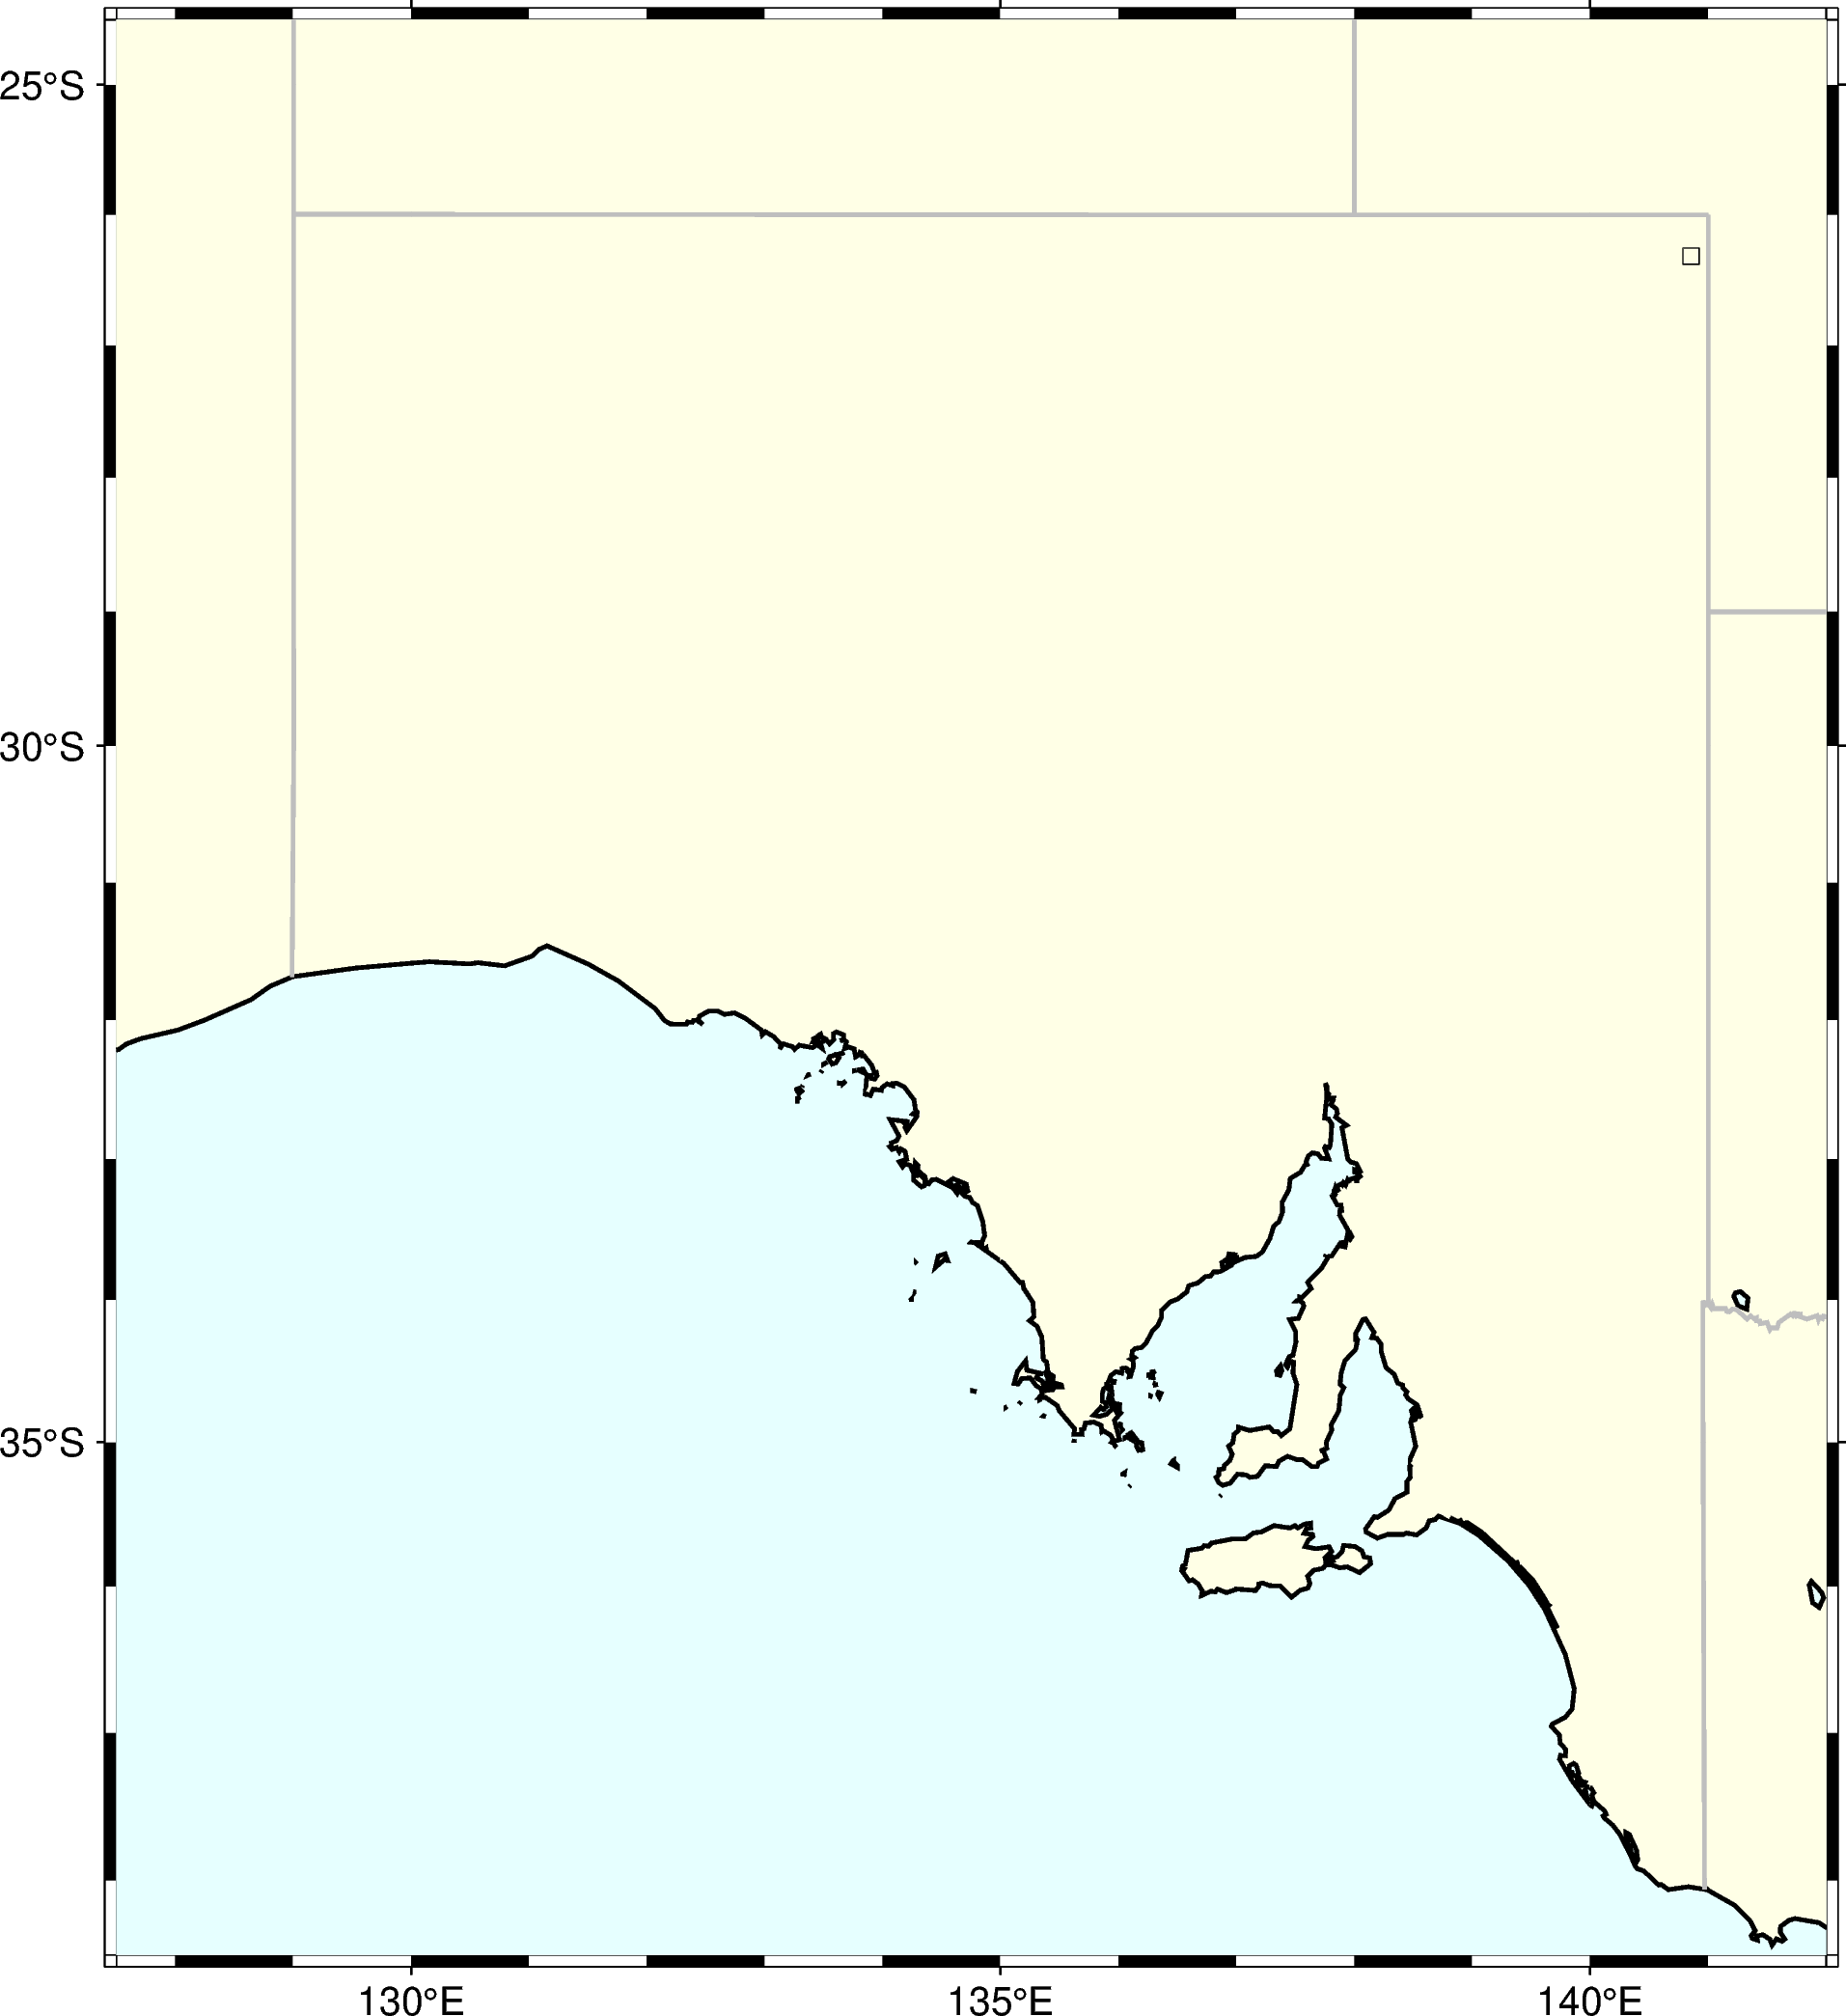

In [165]:
# check we can find a ABSUC borehole close to GSSA borehole
nearest = absuc.iloc[absuc.distance(example_borehole.geometry).argmin()]
fig = pygmt.Figure()
projection = f"M12/11/15"
ln_min, ln_max = (127.5, 142)
lt_min, lt_max = (-38.5, -24.5)
region = [ln_min, ln_max, lt_min, lt_max]
fig.basemap(region=region, projection=projection)
fig.coast(
    shorelines=1,
    land="#ffffe6",
    water="#e6ffff",
    borders="2/1p,grey",
    projection=projection,
    region=region,
)
fig.plot(x=[nearest.GDA94_LONGITUDE],
         y=[nearest.GDA94_LATITUDE],
         style=f"sc",
         pen="0.2p",
         size=[0.2])
fig.show()

In [168]:
units = absuc[absuc["GA_BOREHOLE_GUID"] == nearest["GA_BOREHOLE_GUID"]]
units

,GA_BOREHOLE_GUID,BOREHOLE_NAME,GDA94_LATITUDE,GDA94_LONGITUDE,DATUM_NAME,TD_MD_M,SOURCE_UNIT,GA_UNIT,GA_ASUD_NO,TOP_MD_M,BASE_MD_M,TOP_AHD_M,BASE_AHD_M,Z_AHD_M,HIERARCHY,PREFERRED,geometry
GA_GUID,,,,,,,,,,,,,,,,,
{beb8173d-edfb-4870-867c-06acc4edb7aa},{05edbca8-f30b-44c4-82fb-9b10c8ff06b7},Kitson 1,-26.319301,140.854263,Kelly Bushing (KB),2157.0,Nappamerri Group,Nappamerri Group,13823.0,2009.0,2056.0,-1854.07,-1901.07,-1901.07,250,TB,POINT (140.85426 -26.31930)
{1742b1a8-cfa1-453f-870e-c18560bf5c27},{05edbca8-f30b-44c4-82fb-9b10c8ff06b7},Kitson 1,-26.319301,140.854263,Kelly Bushing (KB),2157.0,Tirrawarra Sandstone/ Merrimelia Formation,Gidgealpa Group,7182.0,2056.0,2133.0,-1901.07,-1978.07,-1978.07,250,TB,POINT (140.85426 -26.31930)
{21a70a50-316e-46c8-a55d-64e661c54348},{05edbca8-f30b-44c4-82fb-9b10c8ff06b7},Kitson 1,-26.319301,140.854263,Kelly Bushing (KB),2157.0,Pre-Permian,PRE-PERMIAN,NaN,2133.0,2157.0,-1978.07,-2002.07,-2002.07,250,TB,POINT (140.85426 -26.31930)


In [250]:
class AUSDScraper:
    """
    A simple scraper, the purpose of which is to determine if a geological unit
    is in a sedimentary province
    """
    def __init__(self):
        self.base_url = "https://asud.ga.gov.au/search-stratigraphic-units/results/"
        self.initalise_driver()

    def initalise_driver(self):
        options = Options()
        options.headless = True
        self.driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)
        self.wait = WebDriverWait(self.driver, timeout=10)

    def get_unit(self, asud_no):
        """
        input: asud_no - unique identifier for the Australian
        Stratigraphic Units Database
        """
        self.driver.get(f"{self.base_url}{asud_no}")
        try:
            element = self.wait.until(lambda driver: driver.find_element(By.XPATH, "//td/div/span/a"))
        except TimeoutException as e:
            print(f"{e} while searching for unit {asud_no}")
        return element
    
    def is_sedimentary(self, asud_no):
        link = self.get_unit(asud_no)
        link.click()
        try:
            table = self.wait.until(lambda driver: driver.find_element(By.XPATH, "//ga-geological-province/div/div[1]/div[1]/table"))
            row = self.wait.until(lambda driver: table.find_element(By.XPATH, ".//tbody/tr[last()]"))
        except TimeoutException as e:
            print(f"{e} while searching for unit {asud_no}")
        
        return True if re.search("Type:\s+sedimentary", row.text) else False
    
    def cleanup(self):
        self.driver.close()
        


In [251]:
scraper = AUSDScraper()
scraper.get_unit(7182)

/var/folders/t6/g_v51vw92p98wh69ncgrb0mh0000gn/T/ipykernel_60053/1750116181.py:12: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
  options.headless = True
/var/folders/t6/g_v51vw92p98wh69ncgrb0mh0000gn/T/ipykernel_60053/1750116181.py:13: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  self.driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)


<selenium.webdriver.remote.webelement.WebElement (session="09f89a5f84b6d7ac067b5ca5c70ea1ff", element="485D87DA6202C67B04B175045D3B66B1_element_26")>

In [252]:
scraper.is_sedimentary(13823)

True

In [253]:
scraper.cleanup()